In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data  # 获取迭代数据
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
from torch.autograd import Variable  # 获取变量

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchvision import models as m 
from torchinfo import summary

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import datetime
import time

import os
import sys

import torchmetrics

In [2]:
# set root path. you can mark directory as source root in PyCharm to achieve the same purpose
project_root = os.path.join(os.path.abspath('.'), '..')
sys.path.insert(0, project_root)

In [8]:
# parse the configure parameters
# from config.config_parser import config_parser

# parser = config_parser()
# args = parser.parse_args(args=['--config', project_root + '/config/test.txt'])
# args.netdepth

In [3]:
#setting
batch_size = 64
learning_rate = 0.01
epochs = 10
clip = 0.01

no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## load data

In [18]:
#imputation后的

all_data = np.load("../input_data/data_imputation.npy")
all_label = np.load("../input_data/label_imputation_binary.npy")

# all_data = np.load("../input_data/data.npy")
# all_label = np.load("../input_data/label.npy")
all_label[all_label != 0] = 1

In [19]:
#包装成数据集
all_data = torch.from_numpy(all_data).to(device)
all_label = torch.from_numpy(all_label).to(device)

all_data = all_data.float()
all_label = all_label.long()
#pack to dataset
dataset = TensorDataset(all_data, all_label)


In [20]:
#划分训练集和测试集

seed = 30
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

num_train = int(len(dataset) * train_ratio)
num_validation = int(len(dataset) * validation_ratio)
num_test = int(len(dataset) - num_train - num_validation)

train_dataset, validation_dataset, test_dataset = random_split(dataset, [num_train, num_validation,num_test],
                                                             torch.Generator().manual_seed(seed))
#Load to DataLoader
print("train_dataset:", len(train_dataset))
print("validation_dataset:", len(validation_dataset))
print("test_dataset:", len(test_dataset))
print("batch_size:", batch_size)

#load to dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



train_dataset: 12333
validation_dataset: 4111
test_dataset: 4112
batch_size: 64


## model

O = (I-K+2P)/S + 1

### EagleC

In [7]:
class EagleC_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        #卷积
        self.features_ = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
                                       , nn.ReLU(inplace=True)
                                       , nn.MaxPool2d(2)

                                       , nn.Conv2d(32, 64, 3, stride=1, padding=1)
                                       , nn.ReLU(inplace=True)
                                       , nn.MaxPool2d(2)
                                       )
        #分类
        #根据net输出的形状确定
        self.clf_ = nn.Sequential(nn.Dropout(0.5)
                                  , nn.Linear(64 * 5 * 5, 512)
                                  , nn.ReLU(inplace=True)
                                #   , nn.Linear(512, 6) 
                                  ,nn.Linear(512, 2) 
                                  , nn.Sigmoid()
                                  )

    def forward(self, x):
        x = self.features_(x)  #用特征提取的架构提取特征
        x = x.view(-1, 64 * 5 * 5)  #调整数据结构，拉平数据
        output = self.clf_(x)
        return output

### Simple net

In [8]:
class example_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        #这个64要好好算，觉得应该是256啊
        self.fc1 = nn.Linear(64,20)
        self.fc2 = nn.Linear(20,10)
        self.fc3 = nn.Linear(10,2)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)#展开
        # x = x.view(-1,16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Resnet

In [9]:
resnet18_ = m.resnet18()
class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=64,kernel_size=3,stride=1,padding=1,bias=False)
                                    ,resnet18_.bn1 
                                    ,resnet18_.relu 
                                     )
        self.block2 = resnet18_.layer2 #128*11*11
        self.block3 = resnet18_.layer3 #256*6*6
        #自适应平均池化+线性层 
        self.avgpool = resnet18_.avgpool #256*1*1
        #输出的线性层
        self.fc = nn.Linear(in_features=256,out_features=2,bias=True)
    
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],256)
        x = self.fc(x)
        return x

## train

In [10]:
def IterOnce(net,criterion,opt,x,y):
    '''
    对模型进行一次迭代的函数
    net:实例化后的架构
    criterion:损失函数
    opt:优化器
    x:一个batch中所有的样本
    y:一个batch中所有样本的真实标签
    '''
    sigma = net.forward(x)
    loss = criterion(sigma, y)
    loss.backward()
    opt.step()
    opt.zero_grad(set_to_none=True)#节省内存
    #预测的标签
    yhat = torch.max(sigma, 1)[1]
    correct = torch.sum(yhat == y)
    return correct,loss

#在测试数据上运行
def TestOnce(net,criterion,x,y):
    '''
    对一组数据进行测试并输出测试结果的函数
    net:训练之后的架构
    criterion：损失函数
    x：要测试的数据的所有样本
    y:要测试的数据的真实标签
    '''
    with torch.no_grad():
        sigma = net.forward(x)
        loss = criterion(sigma, y)
        #最大的就是预测的标签
        yhat = torch.max(sigma, 1)[1]
        correct = torch.sum(yhat == y)
    return correct,loss


#提前停止
class EarlyStopping():
    ''' 
    在测试集上的损失连续几个epochs不再降低的时候，提前停止
    val_loss：测试集/验证集上这个epoch的损失
    '''

    def __init__(self,patience=5,tol=0.0005):
        ''' 
        patience:连续patience个epochs上损失不再降低的时候，停止迭代
        tol:阈值，当新损失与旧损失之间的差异小于tol时，认为模型不再提升
        '''
        self.patience = patience
        self.tol = tol
        self.counter = 0 #连续x次低于tol
        self.lowest_loss = None #用于记录历史最低损失，在没有历史最低损失之前为None
        self.early_stop = False #是否提前停止

    def __call__(self,val_loss):
        ''' 
        val_loss：外部输入的实际损失
        '''
        if self.lowest_loss == None:
            self.lowest_loss = val_loss
        elif self.lowest_loss - val_loss > self.tol:
            self.lowest_loss = val_loss
            self.counter = 0
        elif self.lowest_loss - val_loss < self.tol:
            self.counter += 1
            print("\t NOTICE: Early stopping counter {} of {}".format(self.counter,self.patience))

        
        if self.counter >= self.patience:
            self.early_stop = True
            print("\t NOTICE: Early stopping Activated")
        return self.early_stop


#训练与测试的函数
def fit_test(net,batchdata,testdata,criterion,opt,epochs,tol,modelname,PATH):
    ''' 
    对模型进行训练，并在每个epoch后输出训练集和测试集上的准确率，以实现模型监控
    
    参数说明：
    net:实例化后的网络
    batchdata:使用DataLoader包装后的训练集
    testdata:使用DataLoader包装后的测试集
    criterion:损失函数
    opt:优化器
    epochs:训练的轮数
    tol:提前停止的阈值
    modelname:模型的名称
    PATH:模型的保存路径
    '''

    SamplePerEpoch = batchdata.dataset.__len__()
    allsamples = SamplePerEpoch*epochs
    trainedsamples = 0
    trainlosslist = []
    testlosslist = []
    trainacclist = []
    testacclist = []

    early_stopping = EarlyStopping(patience=5,tol=tol)
    highestacc = None

    for epoch in range(1,epochs+1):
        #训练
        net.train() 
        correct_train = 0
        loss_train = 0
        
        for batch_idx,(x,y) in enumerate(batchdata):
            y = y.view(x.shape[0])
            #写的迭代一次的训练函数
            correct,loss = IterOnce(net,criterion,opt,x,y)
            #计算样本总量、总的correct与loss
            trainedsamples += x.shape[0] #已经训练的样本数量
            
            correct_train += correct
            loss_train += loss

            #监控训练进程
            if (batch_idx+1) % 100 == 0:
                print("\t Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}".format(epoch,trainedsamples,allsamples,100.*trainedsamples/allsamples,loss_train/trainedsamples))

        TrainAccThisEpoch = float(correct_train*100)/SamplePerEpoch
        TrainLossThisEpoch = float(loss_train)/SamplePerEpoch
        trainlosslist.append(TrainLossThisEpoch)
        trainacclist.append(TrainAccThisEpoch)

        #测试
        #测试模式
        net.eval()

        #测试集上的准确率
        correct_test = 0
        loss_test = 0
        TestSample = testdata.dataset.__len__()

        for x,y in testdata:
            y = y.view(x.shape[0])#调整shape
            correct,loss = TestOnce(net,criterion,x,y)
            #计算总的correct与loss
            correct_test += correct
            loss_test += loss

        TestAccThisEpoch = float(correct_test*100)/TestSample
        TestLossThisEpoch = float(loss_test)/TestSample
        testlosslist.append(TestLossThisEpoch)
        testacclist.append(TestAccThisEpoch)     

        #对于每一个epoch，打印训练和测试结果
        print("\t Train Epoch: {} \t Train Loss: {:.6f} \t Train Acc: {:.2f}%".format(epoch,TrainLossThisEpoch,TrainAccThisEpoch))
        print("\t Test Epoch: {} \t Test Loss: {:.6f} \t Test Acc: {:.2f}%".format(epoch,TestLossThisEpoch,TestAccThisEpoch))

        #对于每一个epoch，保存测试集准确率最高的模型的权重
        if (highestacc == None) or (TestAccThisEpoch > highestacc):
            highestacc = TestAccThisEpoch
            torch.save(net.state_dict(),PATH+modelname+'.pt')
            print("\t NOTICE: Model Saved")


        #提前停止
        early_stop = early_stopping(TestLossThisEpoch)

        if early_stop == True:
            print("\t NOTICE: Early Stopping Activated")
            break

    print("【DONE】")
    return trainlosslist,testlosslist,trainacclist,testacclist



def full_procedure(batchdata,testdata,net,epochs,modelname,PATH,lr=0.001,alpha=0.99,gamma=0,tol=10**(-5),wd=0):
    #随机数种子
    torch.manual_seed(1)
    #损失函数
    criterion = nn.CrossEntropyLoss(reduction="sum")

    #优化算法
    opt = optim.RMSprop(net.parameters(),lr=lr,alpha=alpha,momentum=gamma,weight_decay=wd)

    #训练
    trainloss,testloss,trainacc,testacc = fit_test(net,batchdata,testdata,criterion,opt,epochs,tol,modelname,PATH)

    return trainloss,testloss,trainacc,testacc


#绘图函数
def plot_train_test(trainloss,testloss,title):
    plt.figure(figsize=(10,7))
    plt.plot(trainloss,label="Train",color="blue")
    plt.plot(testloss,label="Test",color="red")
    plt.xlabel('Epochs')
    plt.ylabel(title)
    plt.title(title)
    plt.legend()
    plt.show()


In [11]:
PATH = "/share/home/mliu/sc_sv/model"
modelname = "CNN"
print(modelname)
torch.manual_seed(1)

CNN


In [25]:

# net = EagleC_CNN()
# net = example_net()
net = MyResNet()
trainloss,testloss,trainacc,testacc = full_procedure(train_loader,validation_loader,net,epochs=20,modelname=modelname,PATH=PATH)



	 Train Epoch: 1 [6400/246660 (3%)]	 Loss: 0.689748
	 Train Epoch: 1 	 Train Loss: 0.671599 	 Train Acc: 62.20%
	 Test Epoch: 1 	 Test Loss: 0.642204 	 Test Acc: 64.80%
	 NOTICE: Model Saved
	 Train Epoch: 2 [18733/246660 (8%)]	 Loss: 0.219967
	 Train Epoch: 2 	 Train Loss: 0.644378 	 Train Acc: 63.54%
	 Test Epoch: 2 	 Test Loss: 0.649222 	 Test Acc: 62.10%
	 NOTICE: Early stopping counter 1 of 5
	 Train Epoch: 3 [31066/246660 (13%)]	 Loss: 0.132053
	 Train Epoch: 3 	 Train Loss: 0.637662 	 Train Acc: 64.40%
	 Test Epoch: 3 	 Test Loss: 0.658941 	 Test Acc: 60.28%
	 NOTICE: Early stopping counter 2 of 5
	 Train Epoch: 4 [43399/246660 (18%)]	 Loss: 0.093426
	 Train Epoch: 4 	 Train Loss: 0.635650 	 Train Acc: 64.75%
	 Test Epoch: 4 	 Test Loss: 0.647715 	 Test Acc: 65.34%
	 NOTICE: Model Saved
	 NOTICE: Early stopping counter 3 of 5
	 Train Epoch: 5 [55732/246660 (23%)]	 Loss: 0.072497
	 Train Epoch: 5 	 Train Loss: 0.631774 	 Train Acc: 64.91%
	 Test Epoch: 5 	 Test Loss: 0.622662 	 T

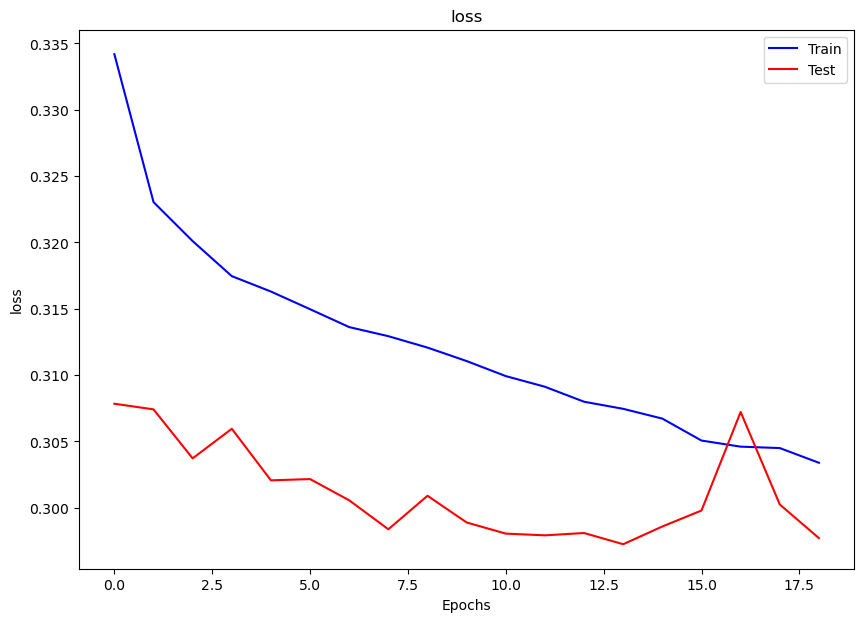

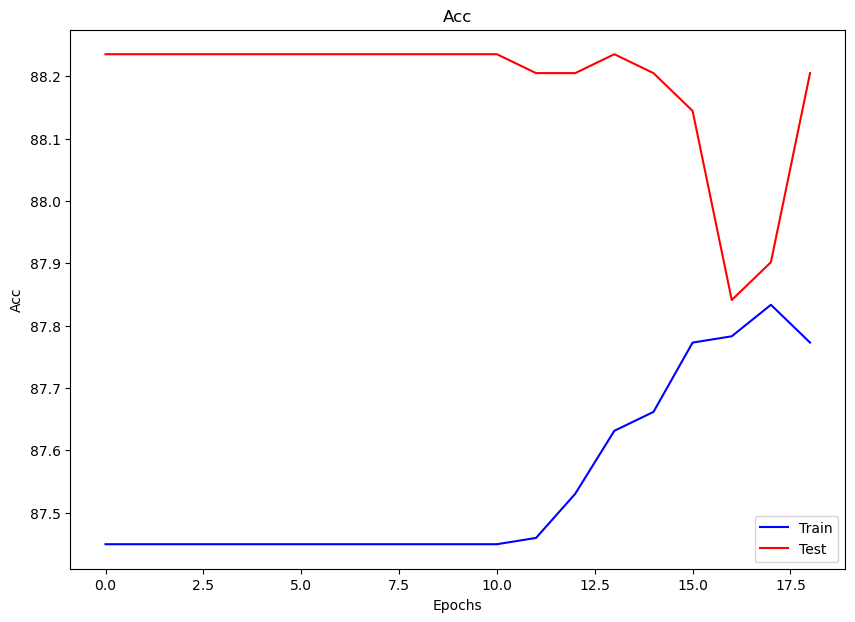

In [13]:
plot_train_test(trainloss,testloss,"loss")
plot_train_test(trainacc,testacc,"Acc")

In [26]:
import torchmetrics
def test_loop(dataloader, model):
    # 实例化相关metrics的计算对象
    test_acc = torchmetrics.Accuracy(task="binary")
    test_recall = torchmetrics.Recall(task="binary",average='none')
    test_precision = torchmetrics.Precision(task="binary",average='none')
    # test_auc = torchmetrics.AUROC(task="binary",average="macro", num_classes=10)

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            # 一个batch进行计算迭代
            test_acc(pred.argmax(1), y)
            # test_auc.update(pred, y)
            test_recall(pred.argmax(1), y)
            test_precision(pred.argmax(1), y)

    test_loss /= num_batches
    correct /= size

    # 计算一个epoch的accuray、recall、precision、AUC
    total_acc = test_acc.compute()
    total_recall = test_recall.compute()
    total_precision = test_precision.compute()
    # total_auc = test_auc.compute()
    print(f"Accuracy: {(100 * correct):>0.1f}%, ")
    print("Recall", total_recall)
    print("Precision", total_precision)
    print("F1", 2*total_recall*total_precision/(total_recall+total_precision))
    # print("auc:", total_auc.item())

    # 清空计算对象
    test_precision.reset()
    test_acc.reset()
    test_recall.reset()
    # test_auc.reset()

In [27]:
test_loop(test_loader, net)

Accuracy: 62.6%, 
Recall tensor(0.5258)
Precision tensor(0.5751)
F1 tensor(0.5493)
